In [1]:
import os
import glob
from datetime import datetime
from collections import defaultdict

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)


In [2]:
rrdp_dir = '../SAGE_RRDP/s_rrdp_jan21'
coll_dir = './collocated'

rrdp_files = sorted(glob.glob(os.path.join(rrdp_dir, '*_N.nc')))
rrdp_dates = [datetime.strptime(os.path.basename(f).split('_')[0], '%Y%m%d') for f in rrdp_files]
coll_files = [f'{coll_dir}/{d.strftime("%Y")}/lagrangian_{d.strftime("%Y%m%d")}.nc' for d in rrdp_dates]
rrdp_coll_date_files = [(date, rf, cf) for date, rf, cf in zip(rrdp_dates, rrdp_files, coll_files) if os.path.exists(cf)]
len(rrdp_coll_date_files), rrdp_coll_date_files[0]

(2129,
 (datetime.datetime(2012, 1, 2, 0, 0),
  '../SAGE_RRDP/s_rrdp_jan21/20120102_N.nc',
  './collocated/2012/lagrangian_20120102.nc'))

In [72]:
pro_fac_ = 1

rrdp_icetypes = ['NIC_dom_icetype', 'autoDMI_dom_icetype', 'AARI_dom_icetype', 'CIS_dom_icetype']
lagr_algos = ['lm', 'newdc', 'nsidc']

min_size = 2000
scores = []
data_for_plotting = None
for date, rf, cf in tqdm(rrdp_coll_date_files):
    ice_type = {}
    with xr.open_dataset(rf) as ds:
        for rrdp_icetype in rrdp_icetypes:
            if rrdp_icetype in ds:
                ice_type[rrdp_icetype] = ds[rrdp_icetype][0].values
    
    
    with xr.open_dataset(cf) as ds:
        lm_myi = ds['lm_myi'][0].values / 100.0
        lm_fyi = ds['lm_fyi'][0].values / 100.0
        newdc_ice_type = ds['newdc_ice_type'][0].values
        nsidc_ice_type = ds['nsidc_ice_type'][0].values

    proba = {}
    proba['lm'] = np.stack([
        (1 - np.exp(- pro_fac_ * lm_fyi)) / (1 - np.exp(-pro_fac_)),
        (1 - np.exp(- pro_fac_ * lm_myi)) / (1 - np.exp(-pro_fac_)),
    ], axis=-1)
    proba['newdc'] = np.zeros((lm_fyi.shape[0], lm_fyi.shape[1], 2))
    proba['newdc'][newdc_ice_type == 2, 0] = 1
    proba['newdc'][newdc_ice_type >= 3, 1] = 1

    proba['nsidc'] = np.zeros((lm_fyi.shape[0], lm_fyi.shape[1], 2))
    proba['nsidc'][nsidc_ice_type == 2, 0] = 1
    proba['nsidc'][nsidc_ice_type >= 3, 1] = 1

    for name in ice_type:
        proba[name] = np.zeros((ice_type[name].shape[0], ice_type[name].shape[1], 2))
        proba[name][(ice_type[name] == 1) | (ice_type[name] == 2), 0] = 1
        proba[name][(ice_type[name] >= 3), 1] = 1
        proba[name][np.isnan(ice_type[name]), :] = np.nan

    proba['rrdp'] = np.zeros((ice_type[name].shape[0], ice_type[name].shape[1], 2))
    for i in [0, 1]:
        proba['rrdp'][..., i] = np.nanmean([proba[name][..., i] for name in ice_type], axis=0)

    if len(ice_type) > 2 and not data_for_plotting:
        data_for_plotting = (ice_type, proba, date)

    mask_brier = ((lm_myi + lm_fyi) > 0) & np.isfinite(proba['lm'][..., 0]) & np.isfinite(proba['newdc'][..., 0]) & np.isfinite(proba['nsidc'][..., 0]) & np.isfinite(proba['rrdp'][..., 0])

    scores_vec = []
    for name in lagr_algos:
        proba_diff = np.mean((proba[name] - proba['rrdp'])**2, axis=-1)
        brier = np.nanmean(proba_diff[mask_brier])
        scores_vec.append(brier)
        
    count = np.sum(~np.isnan(proba_diff[mask_brier]))
    scores.append((date, *scores_vec, count))



100%|██████████| 2129/2129 [00:43<00:00, 49.17it/s]


In [73]:
scores = pd.DataFrame(scores, columns=['date', 'B_lm', 'B_newdc', 'B_nsidc', 'count'])
scores.set_index('date', inplace=True)

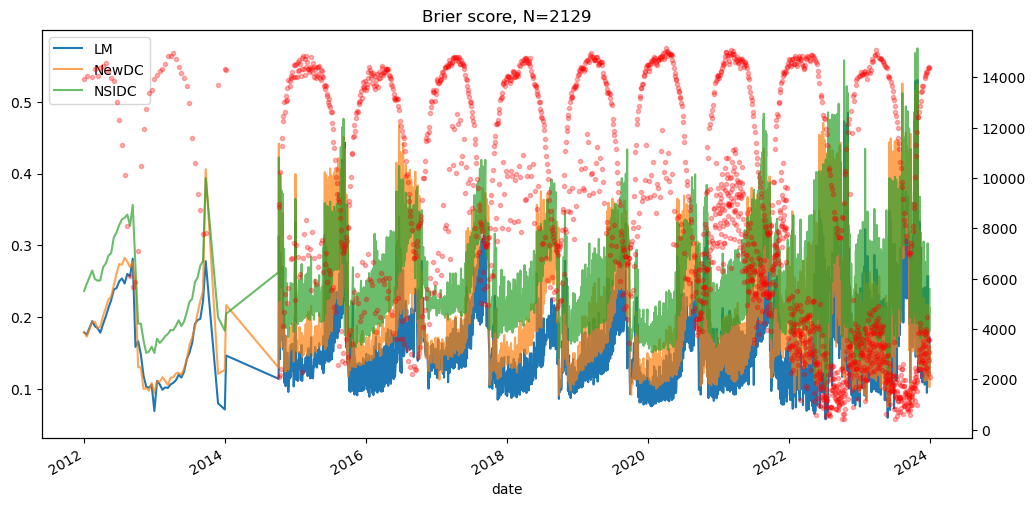

In [74]:
warnings.filterwarnings('ignore', category=UserWarning)

fig = plt.figure(figsize=(12, 6))
scores['B_lm'].plot(label='LM')
scores['B_newdc'].plot(label='NewDC', alpha=0.7)
scores['B_nsidc'].plot(label='NSIDC', alpha=0.7)
#plt.ylim(0.5, 1)
plt.legend()
ax2 = plt.twinx()
ax2.plot(scores.index, scores['count'].values, 'r.', label='Count', alpha=0.3)
#plt.xlim(datetime(2019,10,1), datetime(2020,12,31))
plt.title(f'Brier score, N={scores.shape[0]}')
plt.show()


In [75]:
ice_type, proba, date = data_for_plotting
print(ice_type.keys(), proba['AARI_dom_icetype'].shape, date)

dict_keys(['NIC_dom_icetype', 'AARI_dom_icetype', 'CIS_dom_icetype']) (240, 240, 2) 2012-12-31 00:00:00


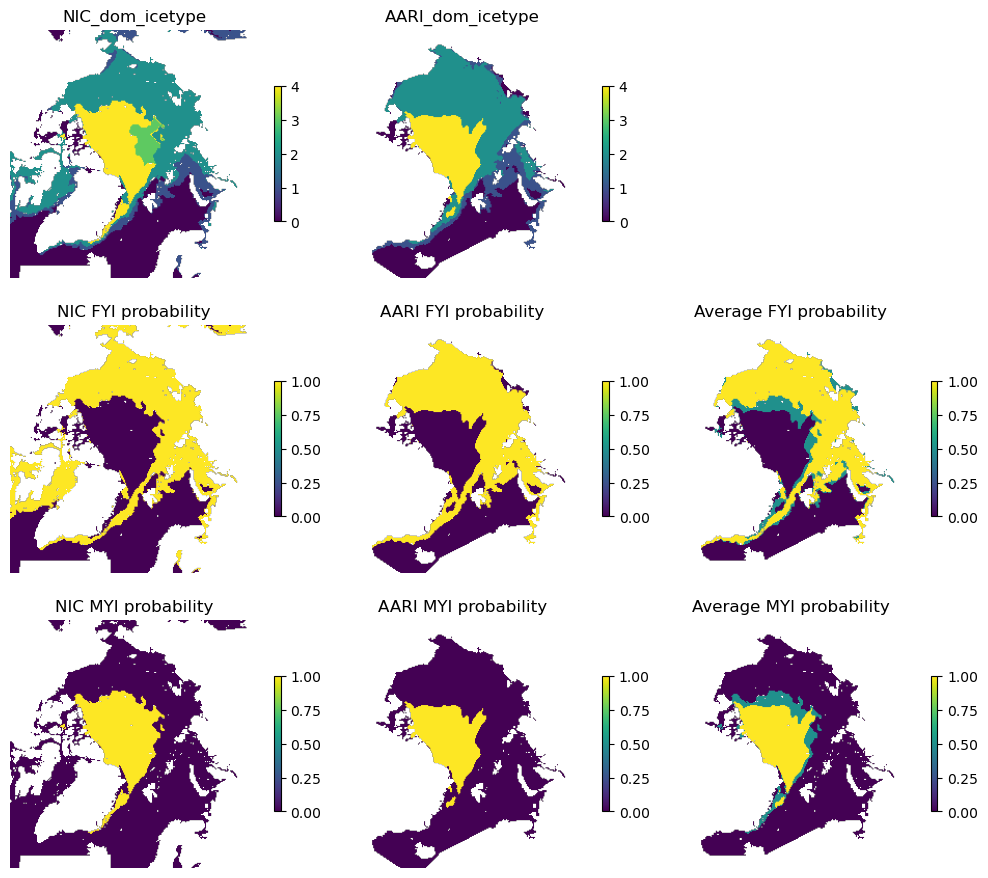

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(10, 9))
for i, name in enumerate(list(ice_type.keys())[:2]):
    img0 = axs[0, i].imshow(ice_type[name])
    axs[0, i].set_title(name)
    axs[1, i].imshow(proba[name][..., 0])
    axs[1, i].set_title(name.split('_')[0]+' FYI probability')
    axs[2, i].imshow(proba[name][..., 1])
    axs[2, i].set_title(name.split('_')[0]+' MYI probability')
    for j in range(3):
        plt.colorbar(axs[j, i].images[0], ax=axs[j, i], shrink=0.5)

axs[1, 2].imshow((proba['NIC_dom_icetype'][..., 0] + proba['AARI_dom_icetype'][..., 0])/2)
axs[1, 2].set_title('Average FYI probability')
axs[2, 2].imshow((proba['NIC_dom_icetype'][..., 1] + proba['AARI_dom_icetype'][..., 1])/2)
axs[2, 2].set_title('Average MYI probability')
for j in range(1, 3):
    plt.colorbar(axs[j, 2].images[0], ax=axs[j, 2], shrink=0.5)
for ax in axs.flat:
    ax.set_axis_off()
plt.tight_layout()
plt.show()

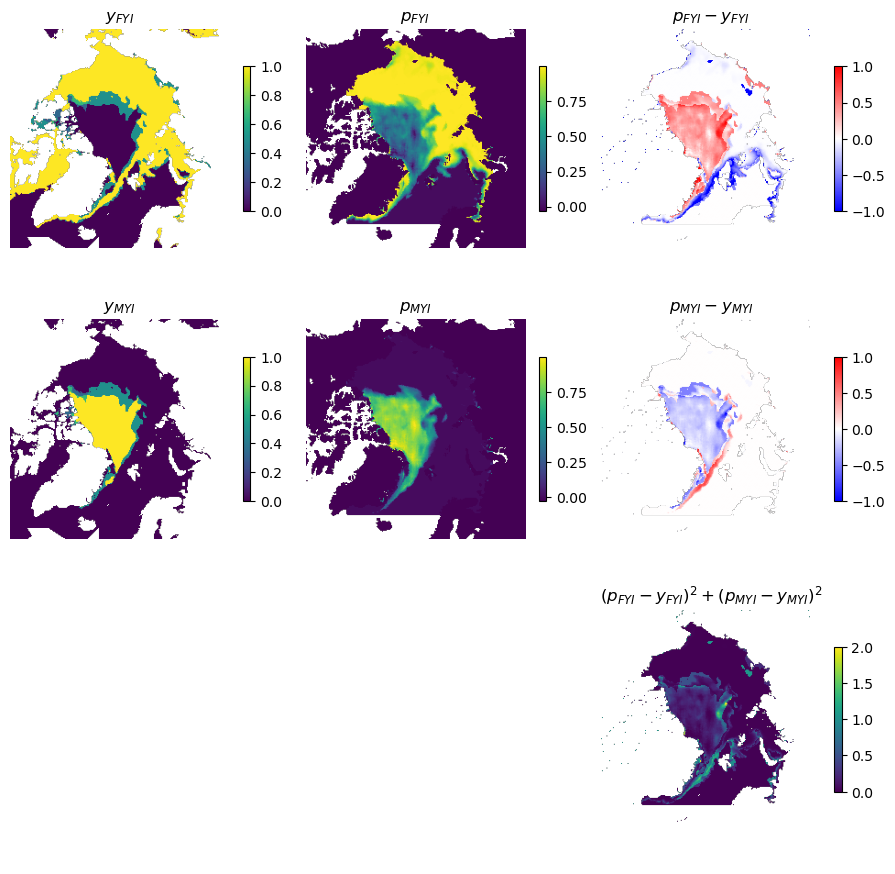

In [78]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
axs[0, 0].imshow(proba['rrdp'][..., 0])
axs[0, 0].set_title('$y_{FYI}$')

axs[1, 0].imshow(proba['rrdp'][..., 1])
axs[1, 0].set_title('$y_{MYI}$')

axs[0, 1].imshow(proba['lm'][..., 0])
axs[0, 1].set_title('$p_{FYI}$')

axs[1, 1].imshow(proba['lm'][..., 1])
axs[1, 1].set_title('$p_{MYI}$')

axs[0, 2].imshow(proba['lm'][..., 0] - proba['rrdp'][..., 0], cmap='bwr', vmin=-1, vmax=1)
axs[0, 2].set_title('$p_{FYI} - y_{FYI}$')

axs[1, 2].imshow(proba['lm'][..., 1] - proba['rrdp'][..., 1], cmap='bwr', vmin=-1, vmax=1)
axs[1, 2].set_title('$p_{MYI} - y_{MYI}$')

proba_diff = np.sum((proba['lm'] - proba['rrdp'])**2, axis=-1)
axs[2, 2].imshow(proba_diff, clim=[0, 2])
axs[2, 2].set_title('$(p_{FYI} - y_{FYI})^2 + (p_{MYI} - y_{MYI})^2$')


for ax in axs.flat:
    ax.set_axis_off()
    if len(ax.images) > 0:
        plt.colorbar(ax.images[0], ax=ax, shrink=0.5)

axs[0, 0].set_ylabel('FYI')
axs[1, 0].set_ylabel('MYI')

plt.tight_layout()

Hello

A = $\^{p}$

Why?